<h1 style="text-align: center;">
A model that can distinguish between female and male faces - if neither it is labeled "Unknown"
</h1>

## Setting up the environment 

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../../FastAi")
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
print(sys.path)

['', '/home/sindre/anaconda3/envs/fastai/lib/python36.zip', '/home/sindre/anaconda3/envs/fastai/lib/python3.6', '/home/sindre/anaconda3/envs/fastai/lib/python3.6/lib-dynload', '/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages', '/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions', '/home/sindre/.ipython', '../../FastAi']


In [3]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import os

## Downloading the images

Downloading the images using a program from https://github.com/hardikvasa/google-images-download and running it through bash scripting locally in the notebook. More possible configurations, such as multiple searchwords, different combinations, etc., but this is enough for now. 

To run this method:
> Using pip
> <div class="alert alert-block alert-info">
> \$ pip install google_images_download
</div> <br>
> Manually using CLI
> <div class="alert alert-block alert-info">
> \$ git clone https://github.com/hardikvasa/google-images-download.git <br>
> \$ cd google-images-download && sudo python setup.py install
> </div> <br>  
> Manually using UI
> <div class="alert alert-block alert-info">
> Go to the repo on github ==> Click on *Clone or Download* ==> Click on *Download ZIP* and save it on your local disk. </div>

<div class="alert alert-block alert-warning">
**NOTE** To download > 100 images, please see GitHub 
</div>

### The specified searchwords will be the classes

### Storing the data in such a way that it matches standard PyTorch folder setup
> <div class="alert alert-block alert-info">
*data/train/className* <br />
*data/valid/className*
</div>

In [23]:
def download_pictures(searchword, form="jpg", lim=100, directory="data/"):
    if not os.path.isdir(directory):
        !mkdir $directory
    ! googleimagesdownload --keywords $searchword --format $form --limit $lim --output_directory $directory --chromedriver "../../../../Downloads/chromedriver" 
    src_path = directory + searchword
    dst_train_path = directory + "train/"
    dst_valid_path = directory + "valid/"
    if not os.path.isdir(dst_train_path and dst_valid_path):
        ! mkdir $dst_train_path
        ! mkdir $dst_valid_path
    if not os.path.isdir(dst_train_path + searchword and dst_valid_path + searchword):
        train_search_folder = dst_train_path + searchword
        valid_search_folder = dst_valid_path + searchword
        ! mkdir $train_search_folder
        ! mkdir $valid_search_folder
    counter = 0
    number_of_files = len(os.listdir(src_path))
    train_ratio = number_of_files*0.7 
    for file in os.listdir(src_path):
        src = src_path + "/" + file
        dst_end = searchword + "/" + searchword + "." + str(counter) + "." + form
        if(counter <= train_ratio):
            dst = dst_train_path + dst_end
        else:
            dst = dst_valid_path + dst_end
        os.rename(src, dst)
        counter = counter + 1
    delete_dir = directory + searchword
    ! rm -rf $delete_dir

### Specifying the desired classes to classify
Because of how the image downloader is set up the word *Image* is used instead of *Unknown*

In [24]:
class1_name = "Female_face"
class2_name = "Male_face"
class3_name = "Image"

In [26]:
%%capture
download_pictures(class1_name, lim=1000);
download_pictures(class2_name, lim=1000);
download_pictures(class3_name, lim=1000);

# Deep Learning
> Utilizing the FastAi framework

## Setting up the necessary PATH to data

In [27]:
PATH = "data/"
os.listdir(PATH)

['valid', 'train']

In [28]:
train_path = PATH + "train/"
valid_path = PATH + "valid/"
print(os.listdir(train_path))
print(os.listdir(valid_path))

['Image', 'Male_face', 'Female_face']
['Image', 'Male_face', 'Female_face']


Possible to get a nicer output of the items in directories? 

In [29]:
class1_path = class1_name + "/"
class2_path = class2_name + "/"
class3_path = class3_name + "/"

In [30]:
print("Training folder: ")
print("Class1: " , os.listdir(train_path + class1_name)[:2])
print("Class2: " , os.listdir(train_path + class2_name)[:2])
print("Class3: " , os.listdir(train_path + class3_name)[:2])

print("Validation folder: ")
print("Class1: " , os.listdir(valid_path + class1_name)[:2])
print("Class2: " , os.listdir(valid_path + class2_name)[:2])
print("Class3: " , os.listdir(valid_path + class3_name)[:2])

Training folder: 
Class1:  ['Female_face.193.jpg', 'Female_face.490.jpg']
Class2:  ['Male_face.400.jpg', 'Male_face.327.jpg']
Class3:  ['Image.549.jpg', 'Image.456.jpg']
Validation folder: 
Class1:  ['Female_face.624.jpg', 'Female_face.628.jpg']
Class2:  ['Male_face.517.jpg', 'Male_face.620.jpg']
Class3:  ['Image.688.jpg', 'Image.784.jpg']


In [31]:
file = os.listdir(train_path + class2_path)[:1]
file

['Male_face.400.jpg']

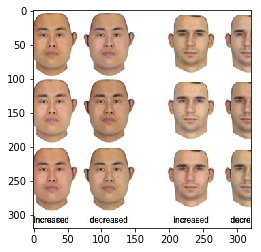

In [32]:
img = plt.imread(train_path + class2_path + file[0])
plt.imshow(img)

In [33]:
img.shape

(320, 320, 3)

In [34]:
img[:4, :4]

array([[[249, 255, 255],
        [249, 255, 255],
        [249, 255, 255],
        [249, 255, 255]],

       [[252, 255, 255],
        [252, 255, 255],
        [251, 255, 255],
        [251, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [254, 255, 255]],

       [[255, 253, 255],
        [255, 253, 255],
        [255, 254, 255],
        [255, 254, 255]]], dtype=uint8)

## Uncomment if needing to resize images 

> <div class="alert alert-block alert-warning">
Possible problems with it storing them in *tmp* folder
</div>

In [ ]:
#from sklearn import metrics 
#
#def get_data(sz, bs):
#    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
#    return data if sz > 300 else data.resize(340, 'tmp');

### Setting training values

In [35]:
arch = resnet34
sz = 299 # One of two standards for ImageNet (224)
bs = 64 

### Data Augmentation
When training for multiple epochs, the model will start overfitting, which basically means the model is learning to recognizing specific images in the training set, rather than generalizing such that it is relevant for other images than just the ones in the training set. 

One quick fix is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

In [36]:
augmentation = transforms_side_on

## Training

In [37]:
tfms = tfms_from_model(arch, sz, aug_tfms=augmentation, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, ps=0.4)
learn.fit(1e-3, 1)

  0%|          | 0/26 [00:00<?, ?it/s]


OSError: Error handling image at: data/train/Image/Image.435.jpg

## Problems because of non-valid image types

> <div class="alert alert-block alert-info">
Can use module *imghdr* to verify image types
</div>

In [38]:
import imghdr
imghdr.what(train_path + class2_path + file[0])

'jpeg'

### Loop through dataset to remove invalid images 

> <div class="alert alert-block alert-info">
But first, interesting to see amount of lost data
</div>

In [39]:
class1_train = train_path + class1_path
class2_train = train_path + class2_path
class3_train = train_path + class3_path
class1_valid = valid_path + class1_path
class2_valid = valid_path + class2_path
class3_valid = valid_path + class3_path

In [41]:
print(class1_name + " training files: " , len(os.listdir(class1_train)))
print(class2_name + " training files: " , len(os.listdir(class2_train)))
print(class3_name + " training files: " , len(os.listdir(class3_train)))
print(class1_name + " validation files: " , len(os.listdir(class1_valid)))
print(class2_name + " validation files: " , len(os.listdir(class2_valid)))
print(class3_name + " validation files: " , len(os.listdir(class3_valid)))

Female_face training files:  516
Male_face training files:  492
Image training files:  605
Female_face validation files:  221
Male_face validation files:  210
Image validation files:  258


In [42]:
file_paths = [class1_train, 
              class2_train,
              class3_train,
              class1_valid, 
              class2_valid,
            class3_valid]
for path in file_paths:
    for files in os.listdir(path):
        if imghdr.what(path + files) != 'jpeg':
            #print("Deleting " + files + " in folder " + path + ", should be " + str(imghdr.what(path+files)))
            os.remove(path + files);

Deleting Female_face.44.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.153.jpg in folder data/train/Female_face/, should be webp
Deleting Female_face.152.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.239.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.220.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.326.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.451.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.501.jpg in folder data/train/Female_face/, should be webp
Deleting Female_face.142.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.234.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.494.jpg in folder data/train/Female_face/, should be None
Deleting Female_face.87.jpg in folder data/train/Female_face/, should be webp
Deleting Female_face.485.jpg in folder data/train/Fema

In [44]:
print(class1_name + " training files: " , len(os.listdir(class1_train)))
print(class2_name + " training files: " , len(os.listdir(class2_train)))
print(class3_name + " training files: " , len(os.listdir(class3_train)))
print(class1_name + " validation files: " , len(os.listdir(class1_valid)))
print(class2_name + " validation files: " , len(os.listdir(class2_valid)))
print(class3_name + " validation files: " , len(os.listdir(class3_valid)))

Female_face training files:  473
Male_face training files:  458
Image training files:  550
Female_face validation files:  204
Male_face validation files:  199
Image validation files:  234


### NOTE: Tried to switch image type from *None* to *JPEG* 
> <div class="alert alert-block alert-info">
In order to minimize data loss. 
</div>

## Updated data set

In [54]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [55]:
learn.fit(1e-2, 3)

 38%|███▊      | 9/24 [00:09<00:15,  1.01s/it, loss=1.24]  


Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.914774   0.544247   0.77865   
    1      0.76972    0.529777   0.78179                   
    2      0.688284   0.506178   0.800628                  



[array([0.50618]), 0.8006279429236611]

In [58]:
learn.fit(1e-2, 3, cycle_len=1)

 17%|█▋        | 4/24 [00:04<00:21,  1.06s/it, loss=0.533]

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.508562   0.491563   0.808477  
    1      0.51122    0.498834   0.797488                  
    2      0.525312   0.486462   0.789639                  



[array([0.48646]), 0.7896389318410793]

# Locate optimal learning rate

epoch      trn_loss   val_loss   accuracy                  
    0      1.424424   1084.725681 0.485086  



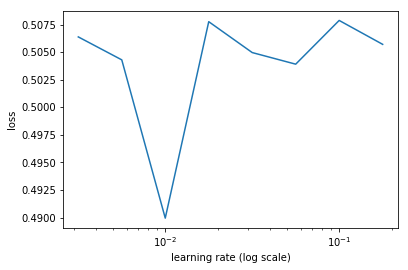

In [59]:
learn.lr_find()
learn.sched.plot()

## Optimal learning rate is a little higher than 1e-2

In [60]:
lr = 0.04

In [61]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.566319   0.48365    0.792779  
    1      0.608986   0.529667   0.791209                  
    2      0.590291   0.505459   0.806907                  
    3      0.582666   0.498848   0.800628                  
    4      0.59097    0.502906   0.791209                  
    5      0.564645   0.493946   0.814757                  
    6      0.55421    0.48617    0.813187                  



[array([0.48617]), 0.8131868145903762]

> Unfreezing the first layers, and checking if there is a new optimal learning rate

 92%|█████████▏| 22/24 [00:26<00:02,  1.19s/it, loss=2.41] 

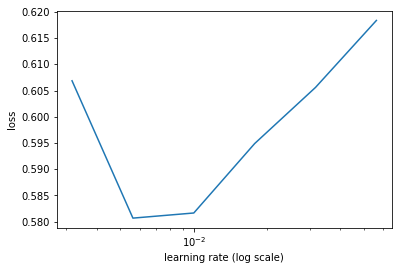

In [62]:
learn.unfreeze()
learn.lr_find()
learn.sched.plot()

In [63]:
lr = 0.03

In [66]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.561914   0.592182   0.762951  
    1      0.620709   0.677798   0.717425                  
    2      0.584492   0.559183   0.78022                   
    3      0.574668   0.651033   0.739403                  
    4      0.560258   0.721249   0.725275                  
    5      0.511775   0.521221   0.791209                  
    6      0.465218   0.498158   0.806907                  
    7      0.44131    0.639048   0.77394                   
    8      0.456437   0.685856   0.756672                  
    9      0.472567   0.700943   0.740973                  
    10     0.462449   0.587913   0.786499                  
    11     0.433397   0.551734   0.797488                  
    12     0.385835   0.539004   0.803768                  
    13     0.334224   0.52004    0.813187                  
    14     0.296432   0.521808   0.827316                  



[array([0.52181]), 0.8273155412269724]

### Checking acuraccy on validation set using Test Time Augmentation
Using the same transforms method as specified *tfms*

In [67]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

accuracy_np(probs, y)

0.8210361067503925

### Saving the model

In [68]:
learn.save("Resnet34_multiclass")

## Visualizing the Data Augmentation
When training for multiple epochs, the model will start overfitting, which basically means the model is learning to recognizing specific images in the training set, rather than generalizing such that it is relevant for other images than just the ones in the training set. 

One quick fix is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

In [69]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [70]:
ims = np.stack([get_augs() for i in range(6)])

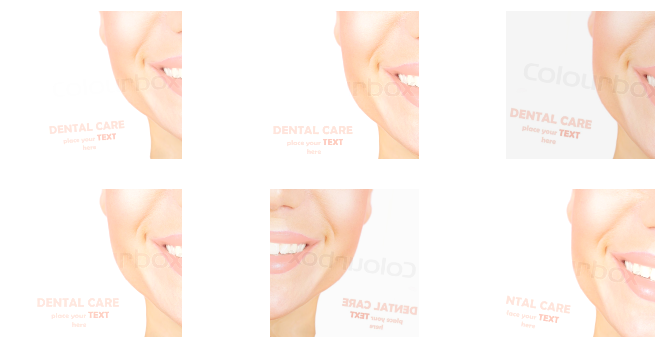

In [71]:
plots(ims, rows=2)

# Can se that the model is *overfitting*

### When *validation loss* >> *training* 

> <div class="alert alert-block alert-info">
Possible solutions: Data Augmentation, Increase dropout, unfreeze and use differential learning rates
</div>

## Not very good results: 82% accuracy and overfitting

### Initially: increase dropout

In [72]:
learn = ConvLearner.pretrained(arch, data, ps=0.65)

In [73]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.140045   0.733322   0.693878  
    1      0.958878   0.567346   0.762951                  
    2      0.861695   0.562504   0.77551                   
    3      0.81624    0.5677     0.766091                  
    4      0.769755   0.522201   0.791209                  
    5      0.728728   0.511553   0.795918                  
    6      0.697969   0.524526   0.792779                  



[array([0.52453]), 0.7927786474886644]

 96%|█████████▌| 23/24 [00:21<00:00,  1.05it/s, loss=5]    

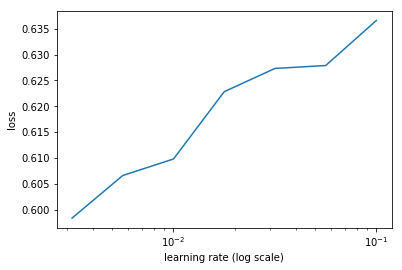

In [74]:
learn.lr_find()
learn.sched.plot()

> Nothing interesting. <br>
> Trying to unfreeze.

In [75]:
learn.unfreeze()

In [76]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/24 [00:00<?, ?it/s]                 


Exception in thread Thread-76:
Traceback (most recent call last):
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.693523   0.524047   0.794349  
    1      0.662753   0.475936   0.800628                  
    2      0.618647   0.45564    0.816327                  
    3      0.572373   0.444599   0.817896                  
    4      0.545661   0.435895   0.816327                  
    5      0.537527   0.424917   0.827316                  
    6      0.508309   0.426904   0.821036                  



[array([0.4269]), 0.8210361061889673]

 92%|█████████▏| 22/24 [00:26<00:02,  1.21s/it, loss=3.21] 

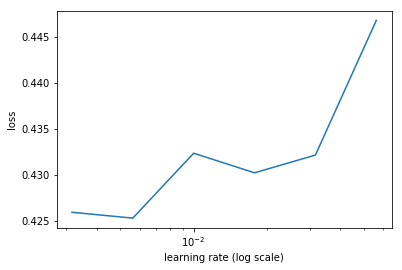

In [77]:
learn.lr_find()
learn.sched.plot()

In [78]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

accuracy_np(probs, y)

0.8273155416012559

In [79]:
learn.save("Resnet34_multiclass")

# Conclusion

> ### Suboptimal, but considering the data set it's all one can expect

## Though, interesting to see if a more powerful model will have an impact

# Trying with a different model: *Resnext50*

In [96]:
arch = resnext50
sz = 299 # One of two standards for ImageNet (224)
bs = 32 

In [104]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, ps=0.6)

In [105]:
learn.fit(1e-3, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.992178   0.553225   0.783359  
    1      0.822247   0.503853   0.803768                  
    2      0.694504   0.485125   0.811617                  



[array([0.48512]), 0.8116169538191013]

 87%|████████▋ | 41/47 [00:21<00:03,  1.95it/s, loss=2.26] 

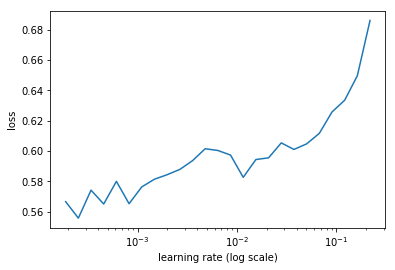

In [106]:
learn.lr_find()
learn.sched.plot()

> No clear optimal learning rate

In [107]:
learn.fit(1e-4, 2, cycle_len=1, cycle_mult=2)

 32%|███▏      | 15/47 [00:07<00:15,  2.10it/s, loss=0.586]


Exception in thread Thread-105:
Traceback (most recent call last):
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.593871   0.485373   0.813187  
    1      0.601716   0.490789   0.810047                  
    2      0.601025   0.481905   0.813187                  



[array([0.48191]), 0.8131868125318171]

 89%|████████▉ | 42/47 [00:20<00:02,  2.01it/s, loss=4.01] 

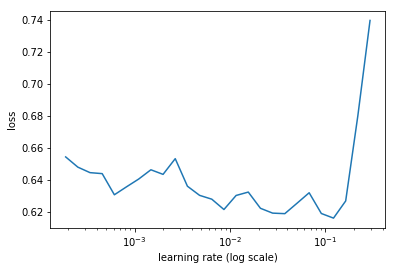

In [108]:
learn.lr_find()
learn.sched.plot()

> Again, no clear cut optimal learning rate, but seems that 1e-2 is the best choice

In [109]:
lr = 1e-2

In [110]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/47 [00:00<?, ?it/s]                    


Exception in thread Thread-109:
Traceback (most recent call last):
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sindre/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.61138    0.472062   0.814757  
    1      0.571162   0.443199   0.830455                  
    2      0.521065   0.437663   0.832025                  
    3      0.55247    0.438621   0.833595                  
    4      0.536631   0.45493    0.830455                  
    5      0.48991    0.465334   0.827316                  
    6      0.460518   0.461445   0.827316                  



[array([0.46144]), 0.8273155419755394]

In [115]:
learn.save("ResNext50_multiclass")

In [111]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [112]:
accuracy_np(probs, y)

0.8335949764521193

In [113]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[168  13  23]
 [  2 224   8]
 [ 47  13 139]]


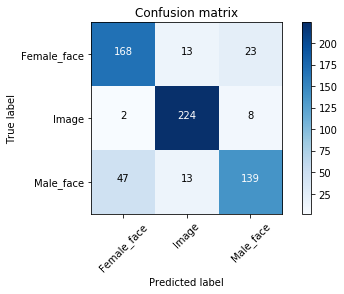

In [114]:
plot_confusion_matrix(cm, data.classes)

# Conclusion

> ## Sligthly better than Resnet34
> ### Considering the data set the result is not too bad